In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

### load in the data.
remember we will not be using the test set until we are happy with our model generated from the train + validate sets

In [5]:
train = pd.read_csv('/content/gdrive/MyDrive/Multimodal Sentiment Analysis/Data/Acoustic Data/TRAIN acoustic data.csv')
validate = pd.read_csv('/content/gdrive/MyDrive/Multimodal Sentiment Analysis/Data/Acoustic Data/VALIDATE acoustic data.csv')

In [6]:
all_float_or_int_features = []

for column in train.columns:
  if (train[column].dtype == 'float64' or train[column].dtype == 'int64') and column not in ['number_of_emotion_tags', 'valence_tags', 'arousal_tags', 'dominance_tags']:
    all_float_or_int_features.append(column)

# combine the train and validate data
train_validate = pd.concat([train, validate], ignore_index=True, sort=False)
del all_float_or_int_features[0]

X_train_validate = train_validate[all_float_or_int_features].replace((np.inf, -np.inf, np.nan), 0)
ytrain_validate_dominance = train_validate['dominance_tags']
ytrain_validate_arousal = train_validate['arousal_tags']
ytrain_validate_valence = train_validate['valence_tags']

### first we need to do feature selection

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, r_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [8]:
X_train = train[all_float_or_int_features].replace((np.inf, -np.inf, np.nan), 0)
y_train = train['valence_tags']
X_test = validate[all_float_or_int_features].replace((np.inf, -np.inf, np.nan), 0)
y_test = validate['valence_tags']

In [9]:
mae_per_k = []
for k_ in range(1,len(X_train.columns)+1):

  # configure to select all features
  skb = SelectKBest(score_func = r_regression, k=k_)

  # learn relationship from training data
  fit = skb.fit(X_train, y_train)

  cols = skb.get_support(indices=True)

  X_train_selected = X_train.iloc[:,cols]
  X_test_selected = X_test.iloc[:,cols]

  # fit the model
  model = LinearRegression()
  model.fit(X_train_selected, y_train)

  # evaluate the model
  y_pred = model.predict(X_test_selected)

  # evaluate predictions
  mae = mean_absolute_error(y_test, y_pred)
  mae_per_k.append(mae)


In [16]:
min(zip(mae_per_k, range(1,len(X_train.columns)+1)))

(1.1013556851060557, 182)

In [10]:
skb = SelectKBest(score_func=r_regression, k=182)

# learn relationship from training data
fit = skb.fit(X_train, y_train)

cols = skb.get_support(indices=True)

X_train_validate_feature_selection = X_train_validate.iloc[:,cols]
X_train_feature_selection = X_train.iloc[:,cols]
X_test_feature_selection = X_test.iloc[:,cols]

### define your grid search for a regression problem
https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
- Grid search allows us to learn the best HYPERparameters (not parameters which are the coefficients learned in the training step from the training data) for a given ML model. Hyperparameters affect the way the chosen algorithm LEARNS.

I always tend to use an EstimatorSelectionHelper (from https://www.davidsbatista.net/blog/2018/02/23/model_optimization/) to do my Grid Search. There are other packages that can help as well.

We can combine the train and validate sets into one for the grid search purpose as it does its own cross validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics))

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV

'''
Classes are like outlines for creating "objects"
Here our object is an EstimatorSelectionHelper.
We will define its attributes (models, params, keys, grid_searches)
as well as its methods (fit(), score_summary())
'''

class EstimatorSelectionHelper:

    # classes always have an __init__ function
    # this initializes (creates) the object with specific parameters (variables)
    # so when we create a new "EstimatorSelectionHelper" object
    # we know we need to pass it two parameters (inputs): models and params

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    # this fit function takes in our training data (we can combine train and validate
    # since this class does its own cross validation) and it fits the list of
    # models you give it with EACH variation of parameter combinations
    # it will return the model + parameter combination and the associated score

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs

    # score summary allows you to print out a table of the models/parameters/scores
    # by default it sorts by the mean score of the K cross validation folds

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [12]:
# now let's define the models and parameters we want to explore in our grid search
# generally, we can just try out all Regression models that sklearn has implemented
# it might take a long time to run but it is good to try all options

# see all regression options on this page: https://scikit-learn.org/stable/supervised_learning.html

# Linear Models
# Kernal Ridge Regression
# Support Vector Machines
# Stochastic Gradient Descent
# Nearest Neighbors
# Gaussian Processes
# Naive Bayes
# Decision Trees
# Neural Networks
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# the more "classic" regression equations
# the three differ by the type of objective function used
models_linear_regression = {'LinearRegression': LinearRegression()}
models_ridge = {'Ridge': Ridge()}
models_lasso = {'Lasso': Lasso()}
# support vector machine
models_SVR = {'SVR': SVR()}
# these two are ensembles of more classic regression equations
models_gradient_boost = {'GradientBoostingRegressor': GradientBoostingRegressor()}
models_ada_boost = {'AdaBoostRegressor': AdaBoostRegressor()}
# random forests are ensembles of decision trees: https://www.saedsayad.com/decision_tree_reg.htm#:~:text=Decision%20tree%20builds%20regression%20or,decision%20nodes%20and%20leaf%20nodes.
models_random_forest = {'RandomForestRegressor': RandomForestRegressor()}
# multi-layer perceptron
models_mlp = {'MLPRegressor': MLPRegressor()}

params_linear_regression = { 'LinearRegression': { }}
params_ridge = {'Ridge': { 'alpha': 10.0**-np.arange(1,7), 'fit_intercept': [True, False], 'solver': ['svd', 'cholesky', 'lsqr', 'sag']}}
params_lasso = {'Lasso': { 'alpha': 10.0**-np.arange(1,7) }}
params_SVR = {'SVR': {'kernel': ['linear'], 'C': [0.05, 0.01], 'degree':[1], 'epsilon':[0.2, 0.5, 1]} }
params_gradient_boost = {'GradientBoostingRegressor': { 'learning_rate': np.logspace(-1.5, 0.5, 10), 'n_estimators': np.linspace(25, 75, endpoint=False, num=15).astype(int), 'min_samples_leaf': [6, 8, 10]}}
params_gradient_boost2 = {'GradientBoostingRegressor': { 'learning_rate': [0.1], 'n_estimators': [100, 200], 'min_samples_leaf': [8,10], 'loss': ['ls'], 'criterion': ['mse']}}
params_ada_boost = {'AdaBoostRegressor': { 'learning_rate': np.logspace(-1.5, 0.5, 10), 'n_estimators': np.linspace(25, 75, endpoint=False, num=15).astype(int) }}
params_random_forest = {'RandomForestRegressor': { 'n_estimators': np.linspace(25, 75, endpoint=False, num=15).astype(int), 'min_samples_leaf': [6, 8, 10] }}
params_mlp = {'MLPRegressor': {}}

'''
(my attempt of drawing a decision tree)
input -> length of audio > 60 seconds -> pitch > 5    ->
                                                      ->
                                      -> pitch < =5
      -> length of audio <= 60 seconds ->
                                        ->
'''


'\n(my attempt of drawing a decision tree)\ninput -> length of audio > 60 seconds -> pitch > 5    ->\n                                                      ->\n                                      -> pitch < =5\n      -> length of audio <= 60 seconds ->\n                                        ->\n'

In [8]:
# usually takes some time to run so for demonstraction I'll comment
# out most of the models but one and show what happens
# you can also do it model by model (aka create a new EstimatorSelectionHelper
# for each model you want to test hypermarameter choices on)
# that way you can move through it model by model and can really get a good feel
# for which models perform better in general (rather than having one huge
# table of results at the end)

GridSearchCV() ranks all the algorithms(estimators) and tells you which one is the best. Now when you use an error function, estimator with higher score will be ranked higher by sklearn, which is not true in the case of MAE (along with MSE and a few others).

To deal with this, the library flips the sign of error, so the highest MAE will be ranked lowest and vice versa.

In [13]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [ ]:
# https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29

In [19]:
models_linear_regression

{'LinearRegression': LinearRegression()}

In [20]:
params_linear_regression

{'LinearRegression': {}}

In [22]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
helper_linear = EstimatorSelectionHelper(models_linear_regression, params_linear_regression)
helper_linear.fit(X_train_validate_feature_selection, ytrain_validate_valence, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
helper_linear.score_summary(sort_by='mean_score')

Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
LinearRegression


,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,-0.790033,-0.75952,-0.718233,0.020476


In [23]:
params_ridge

{'Ridge': {'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
  'fit_intercept': [True, False],
  'solver': ['svd', 'cholesky', 'lsqr', 'sag']}}

In [24]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
helper_ridge = EstimatorSelectionHelper(models_ridge, params_ridge)
helper_ridge.fit(X_train_validate_feature_selection, ytrain_validate_valence, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
helper_ridge.score_summary(sort_by='mean_score')

Running GridSearchCV for Ridge.
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Ridge


,estimator,min_score,mean_score,max_score,std_score,alpha,fit_intercept,solver
24,Ridge,-0.781539,-0.75806,-0.718327,0.019654,0.0001,True,svd
33,Ridge,-0.783865,-0.758079,-0.718224,0.019862,0.00001,True,cholesky
25,Ridge,-0.784058,-0.758099,-0.71788,0.019881,0.0001,True,cholesky
41,Ridge,-0.783014,-0.758214,-0.718458,0.019856,0.000001,True,cholesky
17,Ridge,-0.783582,-0.758329,-0.717002,0.019875,0.001,True,cholesky
16,Ridge,-0.78157,-0.758383,-0.717455,0.019676,0.001,True,svd
32,Ridge,-0.782819,-0.758522,-0.719115,0.019797,0.00001,True,svd
40,Ridge,-0.783157,-0.758659,-0.719276,0.019834,0.000001,True,svd
9,Ridge,-0.78472,-0.759282,-0.717202,0.019869,0.01,True,cholesky
8,Ridge,-0.784058,-0.759432,-0.716986,0.019953,0.01,True,svd


In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
helper_lasso = EstimatorSelectionHelper(models_lasso, params_lasso)
helper_lasso.fit(X_train_validate_feature_selection, ytrain_validate_valence, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
helper_lasso.score_summary(sort_by='mean_score')

Running GridSearchCV for Lasso.
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Lasso


,estimator,min_score,mean_score,max_score,std_score,alpha
5,Lasso,-0.784679,-0.758453,-0.717002,0.019982,0.000001
4,Lasso,-0.786047,-0.759121,-0.715519,0.020348,0.00001
3,Lasso,-0.789134,-0.762583,-0.719964,0.01959,0.0001
2,Lasso,-0.79134,-0.765044,-0.724748,0.018619,0.001
1,Lasso,-0.794935,-0.767375,-0.724929,0.019325,0.01
0,Lasso,-0.800724,-0.772091,-0.731806,0.019059,0.1


In [18]:
# https://towardsdatascience.com/unlocking-the-true-power-of-support-vector-regression-847fd123a4a0#:~:text=Support%20Vector%20Regression%20is%20a,the%20maximum%20number%20of%20points.
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_validate_feature_selection)
X_train_validate_feature_selection_scaled = scaling.transform(X_train_validate_feature_selection)

helper_SVR = EstimatorSelectionHelper(models_SVR, params_SVR)
helper_SVR.fit(X_train_validate_feature_selection_scaled, ytrain_validate_valence, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
helper_SVR.score_summary(sort_by='mean_score')

Running GridSearchCV for SVR.
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVR


,estimator,min_score,mean_score,max_score,std_score,C,degree,epsilon,kernel
0,SVR,-1.129985,-1.110195,-1.071255,0.017547,0.05,1,0.2,linear
1,SVR,-1.130735,-1.1114,-1.073132,0.018162,0.05,1,0.5,linear
3,SVR,-1.133458,-1.114268,-1.076485,0.017268,0.01,1,0.2,linear
4,SVR,-1.134091,-1.115846,-1.078417,0.017923,0.01,1,0.5,linear
2,SVR,-1.143061,-1.123913,-1.089455,0.018184,0.05,1,1,linear
5,SVR,-1.146815,-1.12844,-1.095082,0.01781,0.01,1,1,linear


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_validate_feature_selection)
X_train_validate_feature_selection_scaled = scaling.transform(X_train_validate_feature_selection)

helper_gradient_boost = EstimatorSelectionHelper(models_gradient_boost, params_gradient_boost)
helper_gradient_boost.fit(X_train_validate_feature_selection_scaled, ytrain_validate_valence, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
helper_gradient_boost.score_summary(sort_by='mean_score')

Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
helper_gradient_boost = EstimatorSelectionHelper(models_gradient_boost, params_gradient_boost2)
helper_gradient_boost.fit(X_train_validate_feature_selection, ytrain_validate_valence, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
helper_gradient_boost.score_summary(sort_by='mean_score')

Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 4 candidates, totalling 40 fits
GradientBoostingRegressor


,estimator,min_score,mean_score,max_score,std_score,criterion,learning_rate,loss,min_samples_leaf,n_estimators
1,GradientBoostingRegressor,-0.783657,-0.756565,-0.722042,0.017484,mse,0.1,ls,8,200
0,GradientBoostingRegressor,-0.782608,-0.757023,-0.722934,0.018579,mse,0.1,ls,8,100
2,GradientBoostingRegressor,-0.785899,-0.75754,-0.723497,0.018526,mse,0.1,ls,10,100
3,GradientBoostingRegressor,-0.784675,-0.757632,-0.722878,0.017156,mse,0.1,ls,10,200


In [13]:
# https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
helper_ada_boost = EstimatorSelectionHelper(models_ada_boost, params_ada_boost)
helper_ada_boost.fit(X_train_validate_feature_selection, ytrain_validate_valence, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
helper_ada_boost.score_summary(sort_by='mean_score')

Running GridSearchCV for AdaBoostRegressor.
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
AdaBoostRegressor


,estimator,min_score,mean_score,max_score,std_score,learning_rate,n_estimators
1,AdaBoostRegressor,-1.176181,-1.144659,-1.106658,0.022517,0.031623,28
0,AdaBoostRegressor,-1.177366,-1.14621,-1.109279,0.021894,0.031623,25
2,AdaBoostRegressor,-1.179823,-1.146613,-1.108481,0.023235,0.031623,31
4,AdaBoostRegressor,-1.178667,-1.147392,-1.111365,0.022378,0.031623,38
3,AdaBoostRegressor,-1.180243,-1.147698,-1.110997,0.023187,0.031623,35
...,...,...,...,...,...,...,...
147,AdaBoostRegressor,-1.378899,-1.30869,-1.270212,0.030341,3.162278,65
144,AdaBoostRegressor,-1.338471,-1.308728,-1.267593,0.026193,3.162278,55
148,AdaBoostRegressor,-1.377427,-1.311064,-1.265435,0.029543,3.162278,68
145,AdaBoostRegressor,-1.373835,-1.311843,-1.276731,0.026156,3.162278,58


In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
helper_random_forest = EstimatorSelectionHelper(models_random_forest, params_random_forest)
helper_random_forest.fit(X_train_validate_feature_selection, ytrain_validate_valence, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
helper_random_forest.score_summary(sort_by='mean_score')

Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 45 candidates, totalling 450 fits
RandomForestRegressor


,estimator,min_score,mean_score,max_score,std_score,min_samples_leaf,n_estimators
40,RandomForestRegressor,-1.15719,-1.12129,-1.078983,0.026812,10,58
44,RandomForestRegressor,-1.158556,-1.121416,-1.079841,0.025455,10,71
27,RandomForestRegressor,-1.160261,-1.121423,-1.075712,0.02673,8,65
23,RandomForestRegressor,-1.165591,-1.121652,-1.086171,0.026665,8,51
39,RandomForestRegressor,-1.159831,-1.122181,-1.075999,0.025978,10,55
6,RandomForestRegressor,-1.157415,-1.122329,-1.080936,0.025979,6,45
24,RandomForestRegressor,-1.169395,-1.122435,-1.083936,0.02548,8,55
13,RandomForestRegressor,-1.167959,-1.122557,-1.075536,0.027437,6,68
42,RandomForestRegressor,-1.165717,-1.122569,-1.079653,0.02572,10,65
29,RandomForestRegressor,-1.15944,-1.122574,-1.075335,0.024925,8,71


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
helper_mlp = EstimatorSelectionHelper(models_mlp, params_mlp)
helper_mlp.fit(X_train_validate_feature_selection, ytrain_validate_valence, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
helper_mlp.score_summary(sort_by='mean_score')

Running GridSearchCV for MLPRegressor.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
MLPRegressor


,estimator,min_score,mean_score,max_score,std_score
0,MLPRegressor,-1596062992.144396,-392156637.923223,-19072786.464222,536274867.609927


### Grid search for a neural network looks similar but we wont use the same

*   List item
*   List item

helper class above

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import laskb = SelectKBest(score_func=r_regression, k=64)

SyntaxError: invalid syntax (<ipython-input-2-45e6514dc165>, line 4)

First, in a NN it is good practice to normalize features that use different scales and ranges.


In [ ]:
X_train_feature_selection.describe().transpose()[['mean', 'std']]

,mean,std
acousticbrainz_danceability,1.116085,0.166020
acousticbrainz_onset_rate,3.273201,0.903013
acousticbrainz_chords_strength_dmean,0.010308,0.002290
acousticbrainz_hpcp_entropy_dvar,0.275989,0.052996
acousticbrainz_lowlevel_barkbands_spread_dmean,5.408521,2.329809
...,...,...
acousticbrainz_lowlevel_spectral_contrast_coeffs_var2,0.005474,0.002347
acousticbrainz_lowlevel_spectral_contrast_coeffs_var3,0.003690,0.001653
acousticbrainz_lowlevel_spectral_contrast_valleys_dmean0,0.404389,0.060221
acousticbrainz_lowlevel_spectral_contrast_valleys_dmean1,0.368479,0.070157


In [ ]:
# we can do this with a normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train_feature_selection))
print(normalizer.mean.numpy())

[[ 1.11608481e+00  3.27320099e+00  1.03077004e-02  2.75988966e-01
   5.40851831e+00  5.88544807e+01  1.27839035e+02  2.53018522e+00
   6.15738487e+00  1.49906826e+01  3.87386680e-01  1.80395901e-01
   7.83198547e+00  1.19321918e+01  9.79076462e+01  2.15875183e+02
   1.49953339e+02  3.65218170e+02  1.10038170e+02  2.35958679e+02
   2.11532806e+02  4.82085906e-03  1.84982587e-02  3.69943120e-02
   1.78598389e-02  3.95749025e-02  2.14138794e+02  3.24342377e+02
   9.32430000e+04  1.84289703e+05  1.45362597e+01  2.82917309e+01
   3.74758020e-02  1.00428634e-03  3.38118672e-01  4.14722337e-04
   6.00206491e-04  2.56959535e-02  4.05431502e-02  1.29401265e-03
   5.83665875e+05  8.51380250e+05  7.36145048e+11  1.37840191e+12
   4.52238150e+06  5.30329453e-05  5.30329453e-05  6.54199183e-01
   6.59865748e-07  5.46442209e-07  3.03235669e-02  2.30206624e-02
   1.80298858e-03  1.47807749e-03  6.64387597e-04  4.28696454e-04
  -4.01853919e-01 -4.65579540e-01 -5.34890950e-01  5.47444401e-03
   3.68995

In [ ]:
# now use a tf.keras.Sequential model, which represents a sequence of steps.
# this is a neural network with ONE layer and ONE node
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# fitting the model with train and validate - you can see it does
# its own validation as it learns

history = linear_model.fit(
    X_train_feature_selection,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim()
  plt.xlabel('Epoch')
  plt.ylabel('Error [dominance]')
  plt.legend()
  plt.grid(True)

In [ ]:
linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 64)               129       
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 194
Trainable params: 65
Non-trainable params: 129
_________________________________________________________________


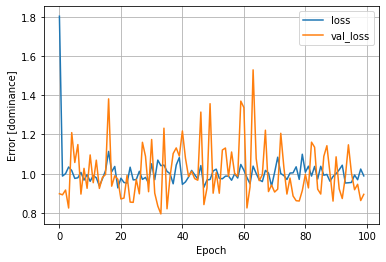

In [ ]:
# The training loss (blue) indicates how well the model is fitting the training data,
# while the validation loss indicates how well the model fits the validation data (20% subsets).
plot_loss(history)

In [ ]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    X_test_feature_selection, y_test, verbose=0)

In [ ]:
test_results

{'linear_model': 0.880026638507843}

That was a single layer neural network so let's try to do better! Basically one node to learn the entire problem

In [ ]:
# here is just a basic model - things we can run a grid search on
# include the number of nodes in the dense layers
# the activation funcitons
# the Adam optimizer
# the rate of the Adam optimization

standard_dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

standard_dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

standard_dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 64)               129       
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,514
Trainable params: 8,385
Non-trainable params: 129
_________________________________________________________________


In [ ]:
history = standard_dnn_model.fit(
    X_train_feature_selection,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

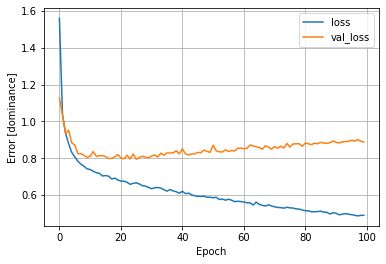

In [ ]:
plot_loss(history)

In [ ]:
test_results['standard_dnn_model'] = standard_dnn_model.evaluate(
    X_test_feature_selection, y_test, verbose=0)

In [ ]:
test_results

{'linear_model': 0.880026638507843, 'standard_dnn_model': 0.874564528465271}

If you're happy with the model, save it for later use with Model.save:


model_name.save('model_name')

reloaded = tf.keras.models.load_model('model_name')

test_results['reloaded'] = reloaded.evaluate(X_test, y_test, verbose=0)

### now we know which model and hyperparameters maximizes our train and validate data so we can load in our test data and test that best model on it for a final score!

In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/Multimodal Sentiment Analysis/Data/Acoustic Data/TEST acoustic data.csv')

In [ ]:
X_test = test[all_float_or_int_features].replace((np.inf, -np.inf, np.nan), 0)
X_test_feature_selection = X_test.iloc[:,cols]
y_test = test['dominance_tags']

In [ ]:
final_model = Ridge(alpha=800, fit_intercept=True, solver='cholesky') # define the best model with the best parameters here
final_model.fit(X_train_validate_feature_selection, ytrain_validate_dominance)

# evaluate the model
y_pred = final_model.predict(X_test_feature_selection)

# evaluate predictions
mae = mean_absolute_error(y_test, y_pred)

print('mean absolute error on test set: ', mae)